# DEEP LEARNING FOR PROTEIN STRUCTURES (Part 2)

## Amino acid and its environment

### 1. Can you recognize the amino acid by its structure?

Take a look at the following structures of amino acids. Can you tell distinguish different amino acids? This table of amino acids might help you in this task.
- N: Blue
- C: Green
- Oxygen: Red
- Sulfur: Yellow

<img src='https://drive.google.com/uc?id=1cltgrjlxVcVkx-TffmExqvBq7jpHxN_L'>

Now take a look at the following amino acids and recognize which structure they belong to.

<img src='https://drive.google.com/uc?id=14TWwgKaHNAjMHyF5Nae_yOT_jI5jkQjC'>

It was easy! no? 
- Did the rotation of the amino acids or changes in the side-chain and backbon torsion angles influence your decisions? 
- What deep learning approach do you propose for the classification of amino acids structures?
- Does traditional CNN do the job for us?

### 2. The environment around residue

<img src='https://drive.google.com/uc?id=1EA0YTjQV_GJsoJyD_TQ-tm2Puo7SXQWJ'>

- 6M0J is a crystal structure of SARS-CoV-2 spike receptor-binding domain (RBD) in interaction with Angiotensin-Converting Enzyme 2 (ACE2). 

- Download the structure of biological assembly of this complex and visualize it in pymol.

- By what experimental method the structure of this complex is determined?

- Select spike glycoprotein (it's chain E). You can do this using command `select Spike, chain E`.

- Select ACE2 (it's chain A). You can do this using command `select ACE2, chain A`.

- Can you identify the interface between these two chains?

- Select residue 382 from chain A and rename it to `centralRes`. Use command `set_name sele, centralRes`. What is the name of this residue and what are it's characteristics?

- Represent this residue with spheres using commands `show spheres, centralRes` and `set sphere_scale 0.6`.

- Select the environment around this residue (6A) and name it `env`. Use command `select env, byres(centralRes around 6) + centralRes`.

- Orient the visualisation on 'env'.

- From the action menu (A) on 'env' find all the polar contacts. `file->polar contacts->whitin selection`.

- Analyze the environment.

- Now repeat the same process for residue 487, 489, 498, and 500 from chain E.

- Present the protein in using balls and sticks

- Select a residue from the interface and change its torsion angles.


## A simple application: prediction of amino acid from its environment

### 1. Locally oriented cubes

A cube with the size of 24×24×24 $Å^3$ is placed on the residue and oriented according to the its backbone structure. Therefore, the architecture is invariant to 3D translations and rotations.

<img src='https://drive.google.com/uc?id=1cuaiYUTfhJwTeJzahumJKlySjV_an0Aa'>

### 2. An end-to-end architecture to predict the amino acid from the environment

In [ ]:
import pandas as pd
import numpy as np
import logging
import seaborn as sns
from scipy import interp
from math import exp
from random import shuffle, random, seed, sample
import matplotlib.pyplot as plt
import time
import os, sys
import glob

!pip install pickle5
import pickle5

import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, AveragePooling3D, Dense, Dropout, Activation, Flatten, Concatenate, Dot, BatchNormalization, Add, Lambda
from tensorflow.keras.backend import ones, ones_like
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, log_loss
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [ ]:
logging.basicConfig(filename='manager.log', filemode='w', format='%(levelname)s: %(message)s', level=logging.DEBUG)
mainlog = logging.getLogger('main')
logging.Logger

logging.Logger

In [ ]:
print('Your python version: {}'.format(sys.version_info.major))

Your python version: 3


In [ ]:
USE_TENSORFLOW_AS_BACKEND = True
FORCE_CPU = False

if USE_TENSORFLOW_AS_BACKEND:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
else:
    os.environ['KERAS_BACKEND'] = 'theano'
if FORCE_CPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
if USE_TENSORFLOW_AS_BACKEND == True:
    import tensorflow
    print('Your tensorflow version: {}'.format(tensorflow.__version__))
    print("GPU : "+tensorflow.test.gpu_device_name())
else:
    import theano
    print('Your theano version: {}'.format(theano.__version__))

Your tensorflow version: 2.6.0
GPU : /device:GPU:0


#### 2.1 Model architecture based on 3D CNN

In [ ]:
def Conv_3D_model(input_shape):
  hidden_size1 = 200
  hidden_size2 = 20
   
  X_in = Input(shape=input_shape)
  #aux_input = Input(shape=input_shape_aux)
  
  #w = tf.Variable(name="custom_weight", initial_value=tf.random.normal(shape=(167,15)))
  #X_ret = Lambda(lambda x: tf.matmul(x, w))(X_in)
  #X_ret = Conv3D(15, kernel_size=(1, 1, 1), padding = 'valid', activation='linear', kernel_initializer='he_uniform', input_shape=X_in.shape)(X_in)
  
  H = Conv3D(20, kernel_size=(1, 1, 1), use_bias = True, padding = 'valid', activation='linear', kernel_initializer='he_uniform', input_shape=X_in.shape)(X_in)
  H = BatchNormalization()(H)
  #H = MaxPooling3D(pool_size=(2, 2, 2))(H)
  H = Conv3D(20, kernel_size=(3, 3, 3), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  #H = MaxPooling3D(pool_size=(2, 2, 2))(H)
  H = Conv3D(30, kernel_size=(4, 4, 4), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  #H = MaxPooling3D(pool_size=(2, 2, 2))(H)
  H = Conv3D(20, kernel_size=(4, 4, 4), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  H = AveragePooling3D(pool_size=(4, 4, 4), strides=(4, 4, 4))(H)
  H = Flatten()(H)
  H = Dropout(0.4)(H)
  
  #H = Concatenate()([H, aux_input])
  
  H = Dense(hidden_size1, activation='elu', name='layer1', kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
  H = Dropout(0.2)(H)
  
  H = Dense(hidden_size2, activation='elu', name='layer2', kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
  H = Dropout(0.1)(H)
  
  Y = Dense(20, activation='softmax')(H)
      
  #Y = Lambda(lambda x: 0.5*(x+1))(H)
  _model = Model(inputs=[X_in], outputs=Y)
  _model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))
  _model.summary()
  return _model

#### Questions
- What activation functions are used in this architecture?
- What is the difference between ELU and ReLU activation functions?
- What cost function are we trying to minimize?
- How many convolutional layers are used in this architecture?
- On which layers dropout technique is used? I invite you to review this [page](https://jmlr.org/papers/v15/srivastava14a.html)

#### 2.2 The input data: locally oriented cubes

Functions to serializing and de-serializing pickle object structure.

In [ ]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle5.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle5.load(f)

In [ ]:
def load_map(train_path):
    X_train, y_train, res_name = load_obj(train_path.replace('.pkl',''))
    return X_train, y_train, res_name

Download two datasets: residue samples with their environments and residue samples without their environments.

In [ ]:
!gdown --id '1ZuY9WMW5gewLVemz8h744KgUwMPyb9EP'
!gdown --id '1qqMNtmlOiMZQ_xo5uNMPZoFaae1P9nYU'

Downloading...
From: https://drive.google.com/uc?id=1ZuY9WMW5gewLVemz8h744KgUwMPyb9EP
To: /content/traindata_30.zip
100% 8.90M/8.90M [00:00<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qqMNtmlOiMZQ_xo5uNMPZoFaae1P9nYU
To: /content/traindata_env_30.zip
100% 80.9M/80.9M [00:00<00:00, 170MB/s]


Decompress the two datasets.

In [ ]:
!unzip '/content/traindata_30.zip'
!unzip '/content/traindata_env_30.zip'

Archive:  /content/traindata_30.zip
  inflating: traindata_30/ALA_1cju_0_1_A_1--1cju_0_1_B_1_10.pkl  
  inflating: traindata_30/ALA_1h4r_0_1_A_1--1h4r_0_1_B_1_17.pkl  
  inflating: traindata_30/ALA_1ixm_0_1_A_1--1ixm_0_1_B_1_31.pkl  
  inflating: traindata_30/ALA_1l9r_0_1_A_1--1l9r_0_1_C_1_58.pkl  
  inflating: traindata_30/ALA_1n1e_0_1_A_1--1n1e_0_1_B_1_98.pkl  
  inflating: traindata_30/ALA_1o9q_0_1_B_1--1o9q_0_1_A_1_67.pkl  
  inflating: traindata_30/ALA_1o9q_0_1_B_1--1o9q_0_1_A_1_68.pkl  
  inflating: traindata_30/ALA_1rj9_0_1_B_1--1rj9_0_1_A_1_12.pkl  
  inflating: traindata_30/ALA_1rj9_0_1_B_1--1rj9_0_1_A_1_70.pkl  
  inflating: traindata_30/ALA_1su6_0_1_A_2--1su6_0_1_A_1_35.pkl  
  inflating: traindata_30/ALA_1yi1_0_1_A_4--1yi1_0_1_A_1_169.pkl  
  inflating: traindata_30/ALA_1yu2_0_1_A_3--1yu2_0_1_A_2_12.pkl  
  inflating: traindata_30/ALA_1zv8_0_2_I_1--1zv8_0_2_G_1_2.pkl  
  inflating: traindata_30/ALA_2a77_0_1_H_1--2a77_0_1_L_1_8.pkl  
  inflating: traindata_30/ALA_2af4_0_1_D_

Load the samples of the residues with or without their environments.

In [ ]:
samples = glob.glob(os.path.join('traindata_30', '*.pkl'))
#samples = glob.glob(os.path.join('traindata_env_30', '*.pkl')) #We will use this line in the end!

In [ ]:
X, y = [],[]
X_train, X_test, y_train, y_test = [],[],[],[]
for sample in samples:
  print('Loading ' + sample)
  sample_X, sample_y, sample_resname = load_obj(sample.replace('.pkl',''))
  X.append(np.array(sample_X))
  y.append(np.array(sample_y))
X = np.array(X)
y = np.array(y)

Loading traindata_30/GLY_1l9u_0_2_L_1--1l9u_0_2_M_1_7.pkl
Loading traindata_30/ASP_1ntz_0_1_A_2--1ntz_0_1_E_2_29.pkl
Loading traindata_30/HIS_2cxt_0_1_B_1--2cxt_0_1_A_1_26.pkl
Loading traindata_30/GLU_1n63_0_1_C_1--1n63_0_1_B_1_46.pkl
Loading traindata_30/GLN_1o5e_0_1_L_1--1o5e_0_1_H_1_3.pkl
Loading traindata_30/ALA_2ywx_0_1_A_6--2ywx_0_1_A_1_20.pkl
Loading traindata_30/ASP_1yi1_0_1_A_4--1yi1_0_1_A_1_40.pkl
Loading traindata_30/PHE_2a77_0_1_H_1--2a77_0_1_L_1_77.pkl
Loading traindata_30/TYR_4h8a_0_1_A_1--4h8a_0_1_B_1_118.pkl
Loading traindata_30/TRP_1n1e_0_1_A_1--1n1e_0_1_B_1_90.pkl
Loading traindata_30/GLN_1cfm_0_1_A_1--1cfm_0_1_C_1_3.pkl
Loading traindata_30/SER_4xdw_0_3_G_1--4xdw_0_3_H_1_4.pkl
Loading traindata_30/MET_5svn_0_1_B_1--5svn_0_1_A_1_115.pkl
Loading traindata_30/ILE_2gs7_0_1_B_1--2gs7_0_1_A_1_2.pkl
Loading traindata_30/THR_5pae_0_1_A_1--5pae_0_1_B_1_48.pkl
Loading traindata_30/VAL_3rex_0_1_B_1--3rex_0_1_A_1_106.pkl
Loading traindata_30/LEU_4bmg_0_1_C_1--4bmg_0_1_D_1_8.pkl


#### 2.3 Split data into train and test sets

In [ ]:
seed(int(np.round(np.random.random()*10)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
del X, y
print(X_test.shape)

(180, 24, 24, 24, 167)


#### 2.4 Training Process

In [ ]:
num_epochs = 20
batch_size = 10
v_dim = 24
n_features = 167

In [ ]:
input_shape=(v_dim,v_dim,v_dim,n_features)
model = Conv_3D_model(input_shape)

# --------------------------------------
# Training
# --------------------------------------
history = model.fit(X_train, y_train, # Train the model using the training set...
                    batch_size=batch_size, epochs=num_epochs,
                    verbose=1, validation_split=0.3) # ...holding out 30% of the data for validation

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 24, 24, 167)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 24, 24, 24, 20)    3360      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 24, 20)    80        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 22, 22, 22, 20)    10820     
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 22, 20)    80        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 19, 30)    38430     
_________________________________________________________________
batch_normalization_2 (Batch (None, 19, 19, 19, 30)    120   

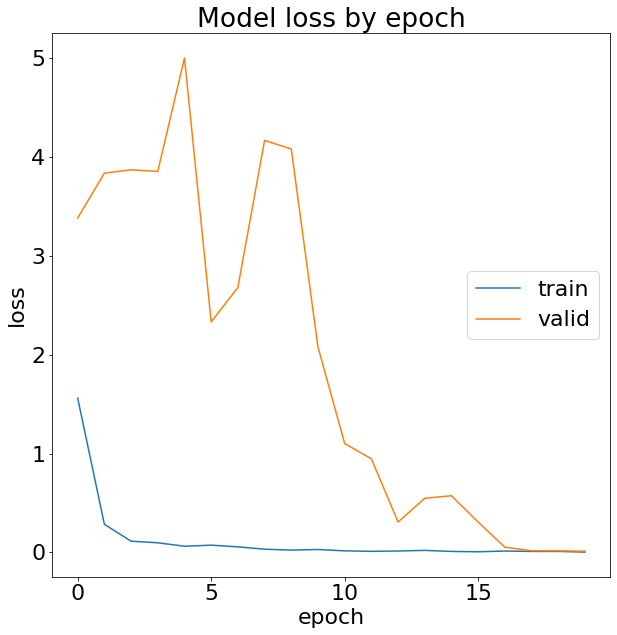

In [ ]:
# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

Question: Is this evaluation of the performance reliable?

#### 2.5 Let's take a look at the performance of the model on test samples.

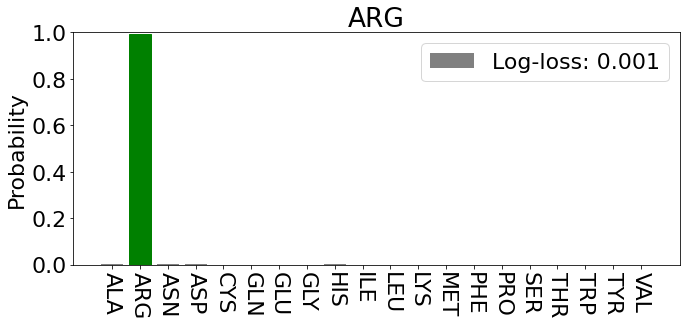

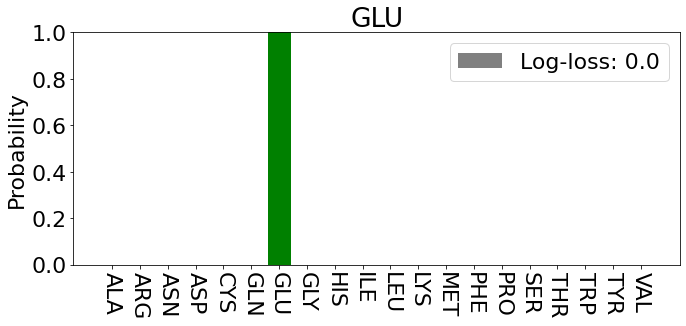

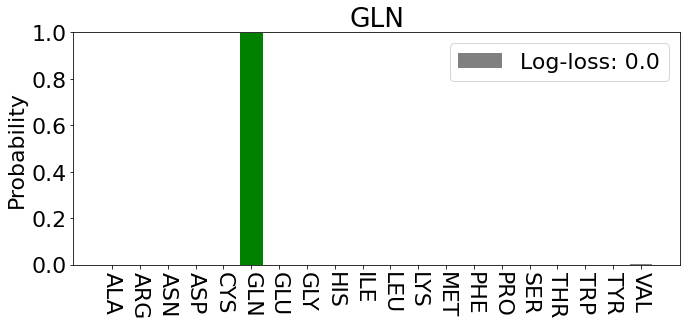

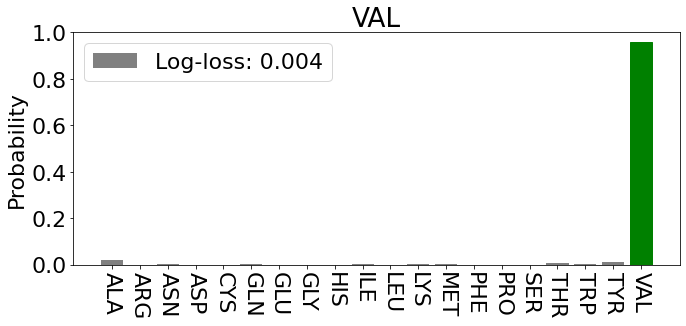

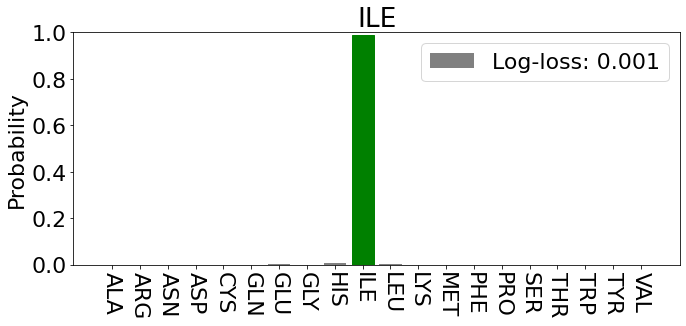

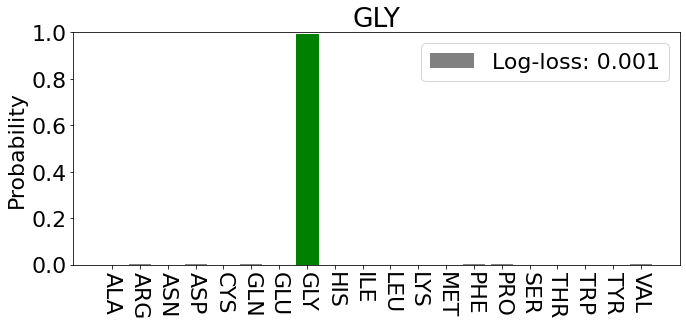

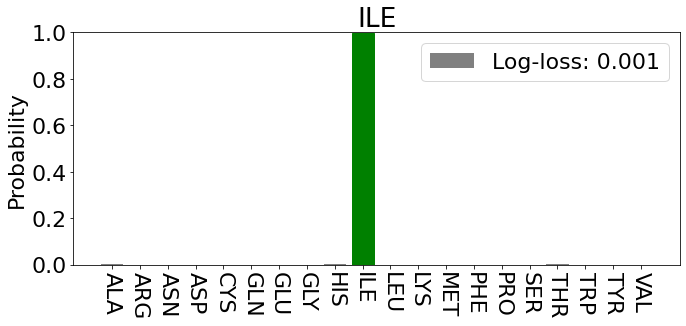

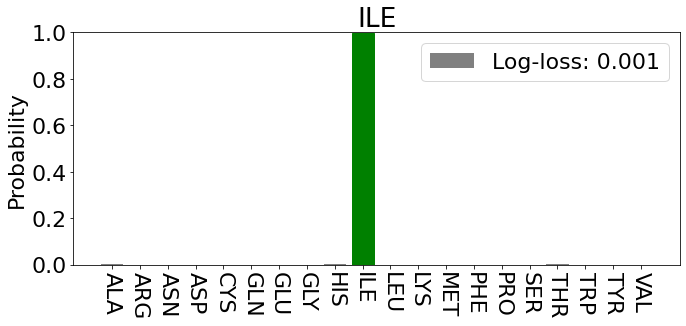

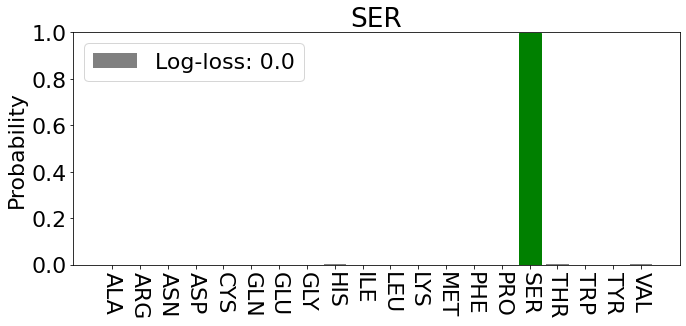

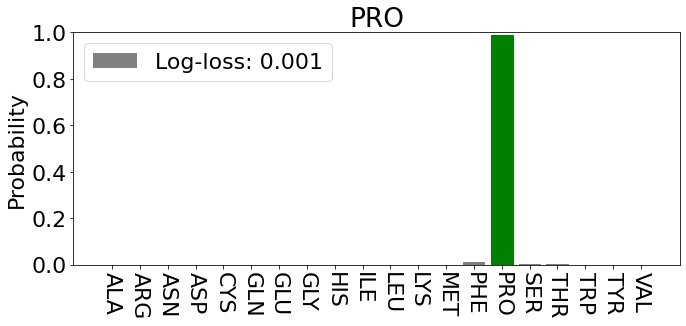

In [ ]:
list_aa = ['CYS', 'ASP', 'SER', 'GLN', 'LYS', 'ILE', 'PRO', 
           'THR', 'PHE', 'ASN', 'GLY', 'HIS', 'LEU', 'ARG', 
           'TRP', 'ALA', 'VAL', 'GLU', 'TYR', 'MET']
list_aa.sort()

plt.rcParams.update({'font.size': 22})

def do_pdf(pred, aa, ll):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1)
    barlist = ax.bar(range(len(list_aa)), pred, color='gray', label='Log-loss: ' + str(ll))
    
    ax.set_xticks(range(len(list_aa)))
    ax.set_xticklabels(list_aa, rotation='-90')
    
    barlist[pred.index(max(pred))].set_color('r')
    barlist[list_aa.index(aa)].set_color('g')

    ax.set_title(aa)
    ax.set_ylabel('Probability')
    ax.set_ylim(0,1)

    plt.tight_layout()
    plt.legend()
    plt.show()

for i in range(10):
  ind = np.random.choice(range(len(X_test)))
  X_t = np.array([X_test[ind]])
  y_t = y_test[ind]
  aa = list_aa[np.argwhere(y_t==1)[0][0]]
  pred = model.predict(X_t, batch_size=X_t.shape[0])[0]
  ll = round(log_loss(y_t, pred), 3)
  do_pdf(list(pred), aa, ll)

In [ ]:
#Clean the memory!
X, y = [],[]
X_train, X_test, y_train, y_test = [],[],[],[]
model = None

#### 2.5 Memorizing versus learning: not too similar not too different!
- Interpret the results. How is the performance of the machine?
- Now repeat the same process but this time load the residue samples with their environments. 

#### 2.6 Discussion
What are the applications of such a model? 

Designed by Yasser MOHSENI BEHBAHANI, LCQB, Sorbonne Université, 2021

<img src='https://drive.google.com/uc?id=1shvaqXgnRa2aCji30gJ02hwI_Ux6NEp6'>
